In [1]:
# import suite2p
import matplotlib.pyplot as plt
import h5py
import suite2p
import re
import datetime
import numpy as np
from skimage.transform import resize

from matplotlib.colors import LinearSegmentedColormap
# from sklearn.decomposition import FastICA

In [2]:
raw = "C:\\Users\\zfj\\data\\081122B\\func\\region4_00001.tif"
reg = "C:\\Users\\zfj\\data\\081122B\\func\\suite2p\\plane0\\reg_tif_chan2\\file{:03d}_chan1.tif"
bing = "C:\\Users\\zfj\\data\\081122B\\func\\suite2p\\plane0\\data.bin"
binr = "C:\\Users\\zfj\\data\\081122B\\func\\suite2p\\plane0\\data_chan2.bin"
timing = "C:\\Users\\zfj\\data\\081122B\\081122B.h5"
mask = "C:\\Users\\zfj\\data\\training\\081122B_region4_72_masks.tif"

In [3]:
tif = suite2p.io.tiff.ScanImageTiffReader(raw)

In [4]:
dotnet_epoch = datetime.datetime(1, 1, 1)
us = datetime.timedelta(microseconds = 1)

a = re.search("epoch = \[((?:\d+.?\d+,?)+)\]", tif.description(0))
t = [float(x) for x in a.groups()[0].split(',')]
t.append(t[-1] % 1 * 1e6)
t = [int(ti) for ti in t]
offset = 10 * (datetime.datetime(*t) - dotnet_epoch) // us 

ts = np.empty((len(tif)//4), dtype=np.int64)

for i in np.arange(0, len(tif), 4):
    a = re.search("frameTimestamps_sec = (\d+.?\d+)", tif.description(i))
    ts[i//4] = float(a.groups()[0]) * 1e7 + offset

# .NET to datetime: datetime.datetime(1, 1, 1) + datetime.timedelta(microseconds = ticks//10)


In [319]:
import pprint
stim_file = h5py.File(timing,"r")
epochs = {
    'start_times':[],
    # 'cx': [],
    # 'cy': [],
}

dotNetOffset = 1e6*60*60 #ticks per hour
def append_epochs(name, g):
    if 'protocolID' in g.attrs and g.attrs['protocolID'] == b'sa_labs.protocols.stage.Chirp': 
        pprint.pprint({k:v for k,v in g['protocolParameters'].attrs.items()})
        # print(g['protocolParameters'].attrs['stimTime'])
        # print(g['protocolParameters'].attrs['preTime'])
        # print(g['protocolParameters'].attrs['tailTime'])
        
        for epoch in g['epochs']:
            # print((g['epochs'][epoch].attrs['startTimeDotNetDateTimeOffsetOffsetHours'],g['epochs'][epoch].attrs['startTimeDotNetDateTimeOffsetTicks']))
            # return
            epochs['start_times'].append(g['epochs'][epoch].attrs['startTimeDotNetDateTimeOffsetTicks'])# - (g['epochs'][epoch].attrs['startTimeDotNetDateTimeOffsetOffsetHours']*dotNetOffset))
            # epochs['start_times'].append(g['epochs'][epoch].attrs['startTimeDotNetDateTimeOffsetTicks'])
            # epochs['cx'].append(g['epochs'][epoch]['protocolParameters'].attrs['cx'])
            # epochs['cy'].append(g['epochs'][epoch]['protocolParameters'].attrs['cy'])
stim_file.visititems(append_epochs)

# plt.scatter(epochs['cx'],epochs['cy'])


{'MstarIntensity1': 158471.7,
 'MstarMean': 0.0,
 'NDF': 2.0,
 'OFFstepTime': 2000.0,
 'ONstepTime': 3000.0,
 'RstarIntensity1': 229463.8,
 'RstarMean': 0.0,
 'SstarIntensity1': 57570.4,
 'SstarMean': 0.0,
 'bitDepth': 8.0,
 'blueLED': 40.0,
 'chan1': b'Amp1',
 'chan1Hold': 0.0,
 'chan1Mode': b'Cell attached',
 'colorPattern1': b'uv',
 'colorPattern2': b'none',
 'colorPattern3': b'none',
 'contrastFreq': 2.0,
 'contrastMax': 1.0,
 'contrastMin': 0.0,
 'contrastTotalTime': 8000.0,
 'doPWM': 0,
 'forcePrerender': b'auto',
 'frameRate': 60.0,
 'freqMax': 8.0,
 'freqMin': 0.0,
 'freqTotalTime': 8000.0,
 'greenLED': 10.0,
 'imaging': 0,
 'intensity': 0.5,
 'interTime': 2000.0,
 'meanLevel': 0.0,
 'numberOfEpochs': 50.0,
 'numberOfPatterns': 1.0,
 'offsetX': 0.0,
 'offsetY': 0.0,
 'preTime': 3000.0,
 'prerender': 0,
 'sampleRate': 10000.0,
 'scanHeadTrigger': 0,
 'spikeDetectorMode': b'advanced',
 'spikeThreshold': -6.0,
 'spotSize': 100.0,
 'stimTime': 27000.0,
 'stimTimeRecord': 1,
 'tailT

In [7]:
idx = np.abs(np.expand_dims(epochs['start_times'],axis=0) - np.expand_dims(ts,axis=1)).argmin(axis=0)
idx_missing = np.union1d(np.where(idx==len(ts)-1), np.where(idx==0))
epochs['start_times'] = np.delete(epochs['start_times'], idx_missing)
idx = np.delete(idx, idx_missing)


In [28]:
frame_i = np.expand_dims(idx,axis=0) + np.expand_dims(np.arange(0,1083),axis=1)
print(idx.shape, frame_i.shape)
# 33/(np.median(np.diff(ts))/1e7)

(43,) (1083, 43)


In [29]:
m = suite2p.io.tiff.open_tiff(mask, True)[0].pages[0].asarray()

def segment_ds(path):
    data = suite2p.io.BinaryRWFile(32, 128, path).data[frame_i.flatten()]
    act = np.empty((len(data),int(m.max())))
    for i in range(int(m.max())):
        m_i = resize((m==i+1).astype(np.float64), (32,128), anti_aliasing=True)
        m_i /= m_i.sum()
        m_i = m_i.reshape((1,32,128)).repeat(len(data), 0)

        act[:,i] = (m_i * data).mean(axis=(1,2))
    
    return act.reshape((*frame_i.shape, -1))

g = segment_ds(bing)
gr = g / segment_ds(binr)

(1083, 43, 162)


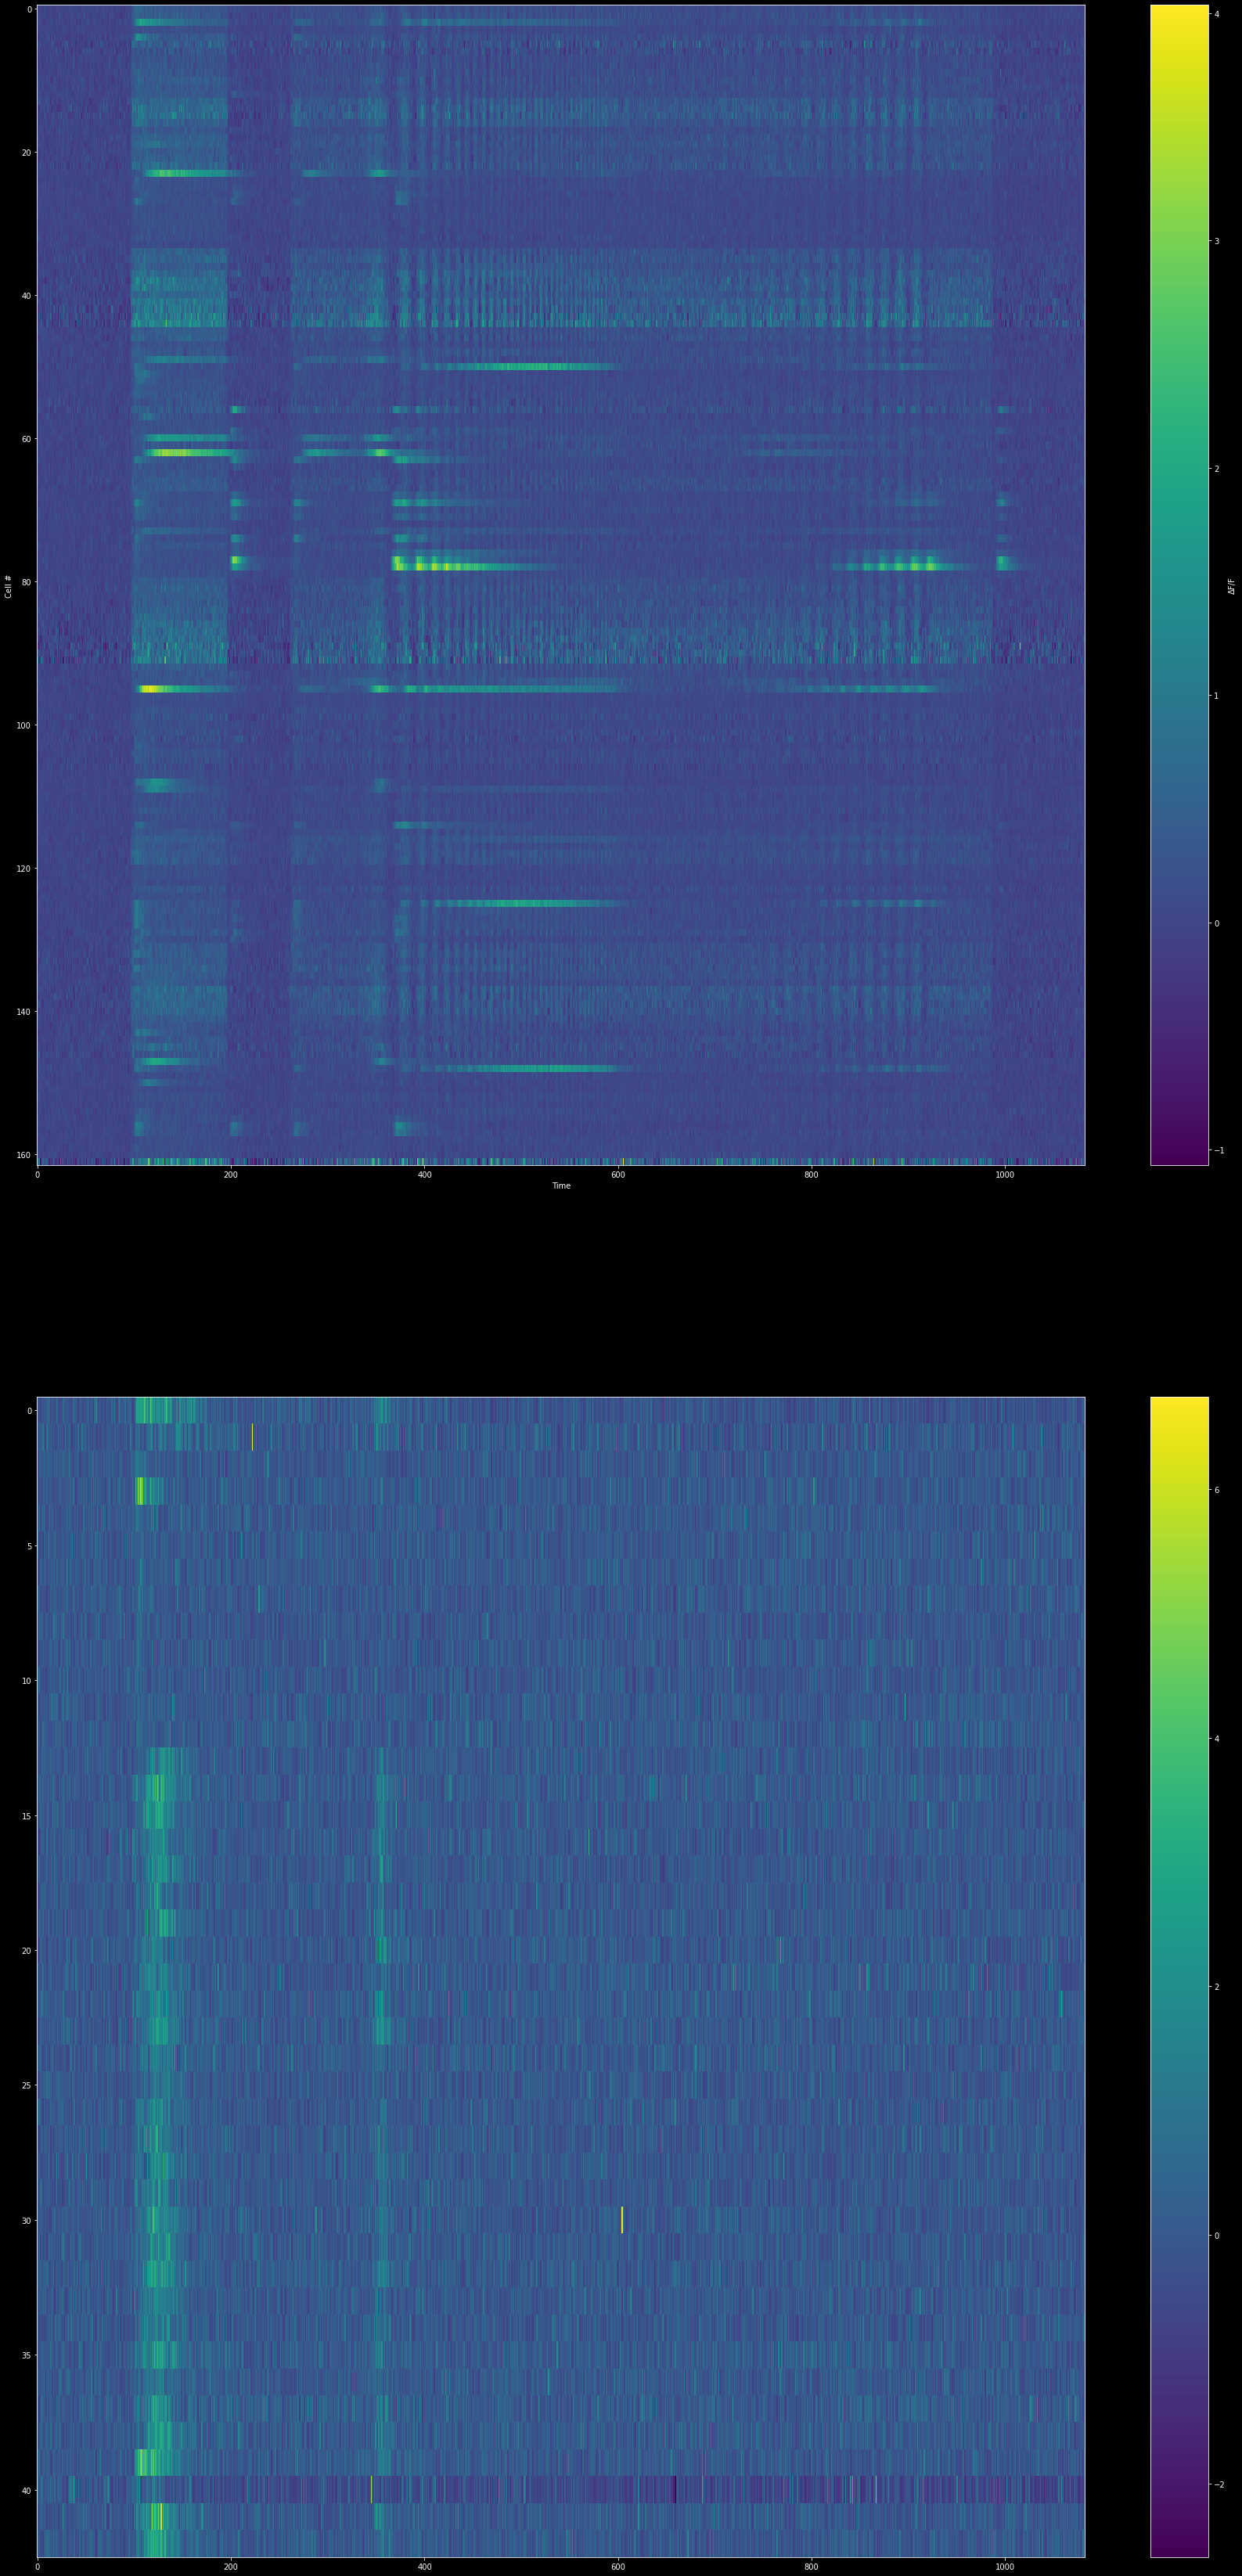

In [333]:
dFoF = (g - g[:98,:,:].mean(axis=0)) / g[:98,:,:].mean(axis=0)

print(dFoF.shape)
ci = 108


fig,ax = plt.subplots(2,1, figsize=(30,60))
# im0 = ax[0].imshow((dFoF.mean(axis=1).T - dFoF.mean(axis=(0,1))[:,np.newaxis]) / dFoF.mean(axis=1).std(axis=0)[:,np.newaxis], aspect='auto', interpolation='nearest')
im0 = ax[0].imshow(dFoF.mean(axis=1).T, aspect='auto', interpolation='nearest')
im1 = ax[1].imshow(dFoF[:,:,ci].T, aspect='auto', interpolation='nearest')

# im0=ax[0].imshow(g.mean(axis=1).T, aspect='auto', interpolation='nearest')
# im1=ax[1].imshow(g[:,:,ci].T, aspect='auto', interpolation='nearest')

cb = fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

ax[0].set_xlabel('Time')
ax[0].set_ylabel('Cell #')
cb.set_label('ΔF/F')



plt.show()

(1083, 43, 162)


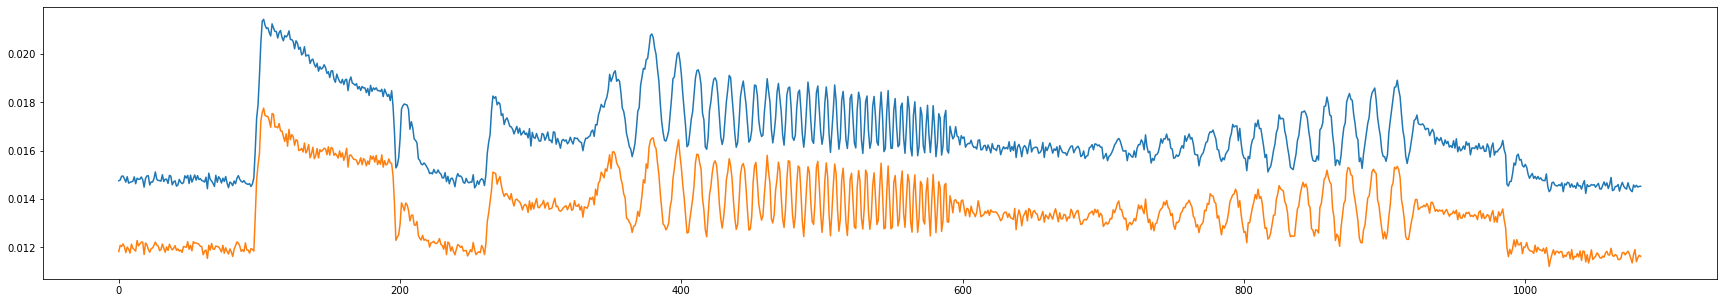

In [54]:
dFoF.shape

f = plt.figure(figsize=(30,5))
plt.plot(np.mean(g, axis=(1,2)))
plt.plot(np.median(g, axis=(1,2)))

print(g.shape)


(1083, 43, 162)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 40] [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42]


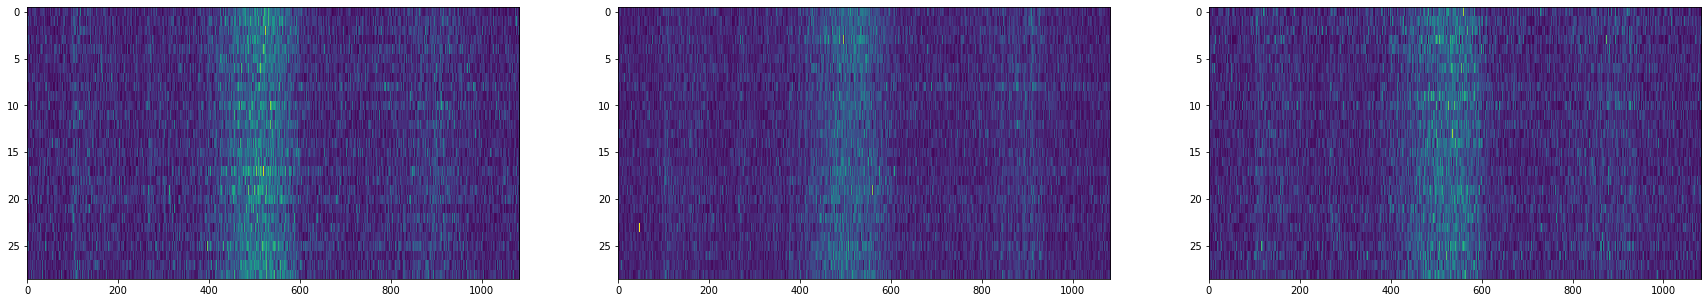

In [134]:
fig,axs = plt.subplots(1,3,figsize=(30,5))
print(dFoF.shape)
exclude = [*list(range(13)), 40]
trial_ind = [x for x in range(43) if x not in exclude]
print(exclude, trial_ind)
axs[0].imshow(dFoF[:,trial_ind,50].T, aspect='auto', interpolation='nearest')
axs[1].imshow(dFoF[:,trial_ind,125].T, aspect='auto', interpolation='nearest')
axs[2].imshow(dFoF[:,trial_ind,148].T, aspect='auto', interpolation='nearest')

In [61]:
from scipy.io import loadmat
M = loadmat("BadenEtAl_RGCs_2016_v1.mat")

In [114]:
# plt.plot(np.linspace(0, 33, 31988),M['chirp_stim'])
print(M.keys())
print(np.unique(M['group_idx']))
print(np.unique(M['cluster_idx']))


dict_keys(['__header__', '__version__', '__globals__', 'ans', 'noise_time', 'noise_trace', 'noise_stim', 'cluster_idx', 'group_idx', 'c2g', 'sel_idx', 'cell_dsi', 'cell_dp', 'cell_osi', 'cell_op', 'cell_area', 'cell_volume', 'cell_id', 'cell_oo_idx', 'cell_ff_idx', 'chirp_avg', 'chirp_byrepeat', 'chirp_time', 'chirp_stim', 'chirp_stim_time', 'chirp_qi', 'chirp_scaling', 'bar_byrepeat', 'bar_tc', 'bar_qi', 'bar_time', 'rf_tc', 'rf_time', 'rf_qi', 'rf_size', 'rf_map', 'rf_gauss_mean', 'rf_gauss_std', 'color_avg', 'color_byrepeat', 'color_time', 'color_qi', 'immuno_gad', 'immuno_chat', 'immuno_smi', 'immuno_melanopsin', 'genetics_pv', 'genetics_pcp', 'structural', 'rois', 'offsets'])
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
[-1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 5

[-2  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74]
(249, 11210)
(74, 249)


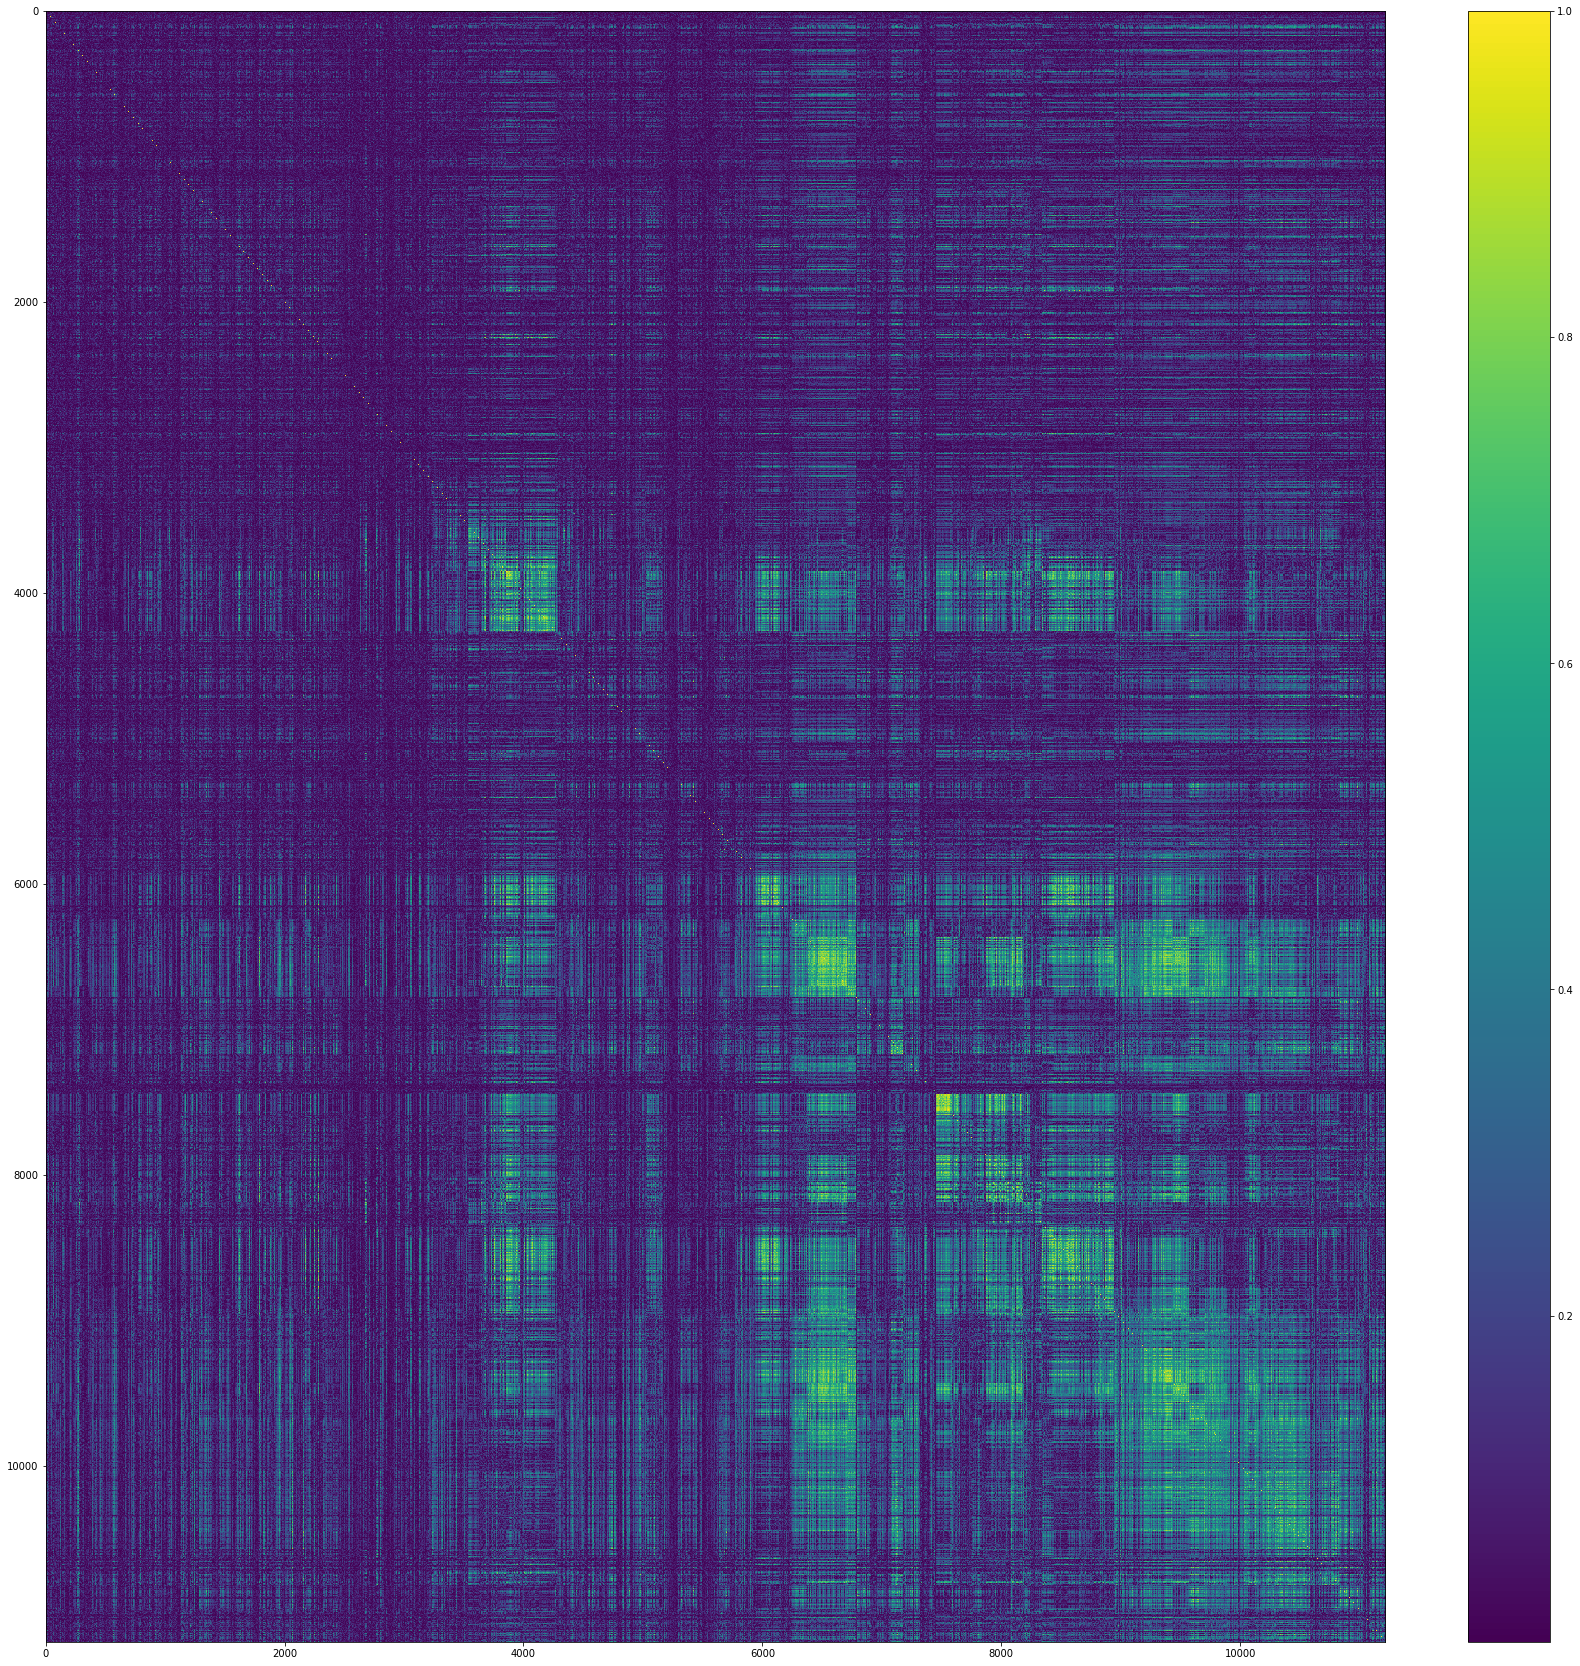

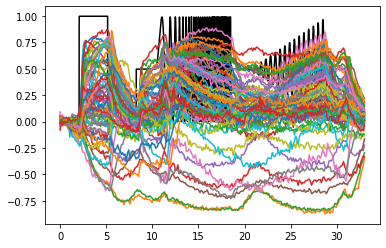

In [123]:
M.keys()
# print(M['cluster_idx'].shape, M['chirp_avg'].shape)
ci = M['cluster_idx'].flatten() - 1
print(np.unique(ci))
l = np.argsort(ci)
CA = M['chirp_avg'][:,l]

# print(CA.shape, l.shape)

plt.figure(figsize=(30,30))
plt.imshow(np.abs(np.corrcoef(CA.T)),aspect='auto', interpolation='nearest')
plt.colorbar()

print(CA.shape)
clust_avg = np.array([M['chirp_avg'][:, ci==i].mean(axis=1) for i in range(ci.max())])
print(clust_avg.shape)

plt.figure()
plt.plot(np.linspace(0, 33, 31988),M['chirp_stim']/256, color='k')
plt.plot(np.linspace(0, 33, 249), clust_avg.T)


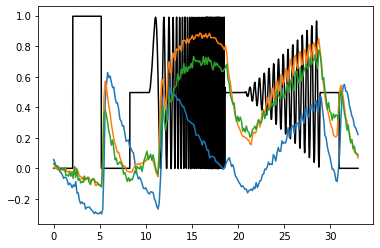

In [124]:
plt.figure()
plt.plot(np.linspace(0, 33, 31988),M['chirp_stim']/256, color='k')
# plt.plot(np.linspace(0, 33, 249),np.array(M['chirp_avg'][:,M['cluster_idx'].flatten()==6]))
# plt.plot(np.linspace(0, 33, 249),np.array(M['chirp_avg'][:,M['cluster_idx'].flatten()==6]).mean(axis=1))


plt.plot(np.linspace(0, 33, 249), clust_avg[5:8].T)

(1083, 162) (74, 249)
(162, 1083) (74, 1083)
[16 65 64 34 73 34 16 34 34 16 65 34 65 34 65 34 33 65 59 16 33 65 16 70
 65 68 68 73 65 16 16 16 16 33 65 34 33 33 65 65 65 65 65 65 65 65 65 59
 33 16 54 73 16 16 65 65 67 16 65 67 70 16 70 66 68 34 34 34 35 71 69 68
 34 65 71 68 10 35 10 35 34 34 65 65 34 16 65 34 34 65 65 65 34 65 34 61
 65 67 59 59 16 34 68 73 16 65 59 16 73 16 34 65 16 65 66 65 33 68 33 65
 34 16 16 16 33 54 64 68 65 68 73 65 65 34 65 65 16 65 65 59 65 65 59 73
 65 16 65 73 55 65 37 65 65 16 61 73 73 66 65 16 16 65  1]
[54 54 55]


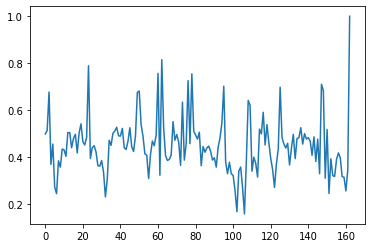

In [160]:
# plt.imshow(dFoF[:,trial_ind,:].mean(axis=1).T,aspect='auto', interpolation='nearest')
print(dFoF[:,trial_ind,:].mean(axis=1).shape, clust_avg.shape)

from scipy.signal import resample

clust_up = resample(clust_avg.T, 1083)

print(dFoF[:,trial_ind,:].mean(axis=1).T.shape, clust_up.T.shape)

cc = np.corrcoef(dFoF[:,trial_ind,:].mean(axis=1).T, clust_up.T)
cmatch = cc[162:,:163].argmax(axis=0)
plt.plot(cc[162+cmatch,:163].max(axis=0))

print(cmatch + 1)
(cmatch+1 > 49).mean()

print(cmatch[[50, 125, 148]] + 1)

In [190]:
raw_dat = tif.data().reshape((-1,4,32,128))[frame_i.flatten(),:,:,:].reshape((*frame_i.shape,4,32,128))#.shape #(629944, 32, 128)
#.shape #(46569,)
# 629944/4

In [241]:
3+3+2+2+8+2+8+2+3

33

(1083, 43, 4, 32, 128)
16384 0.06415421686746987 31.82049156626506


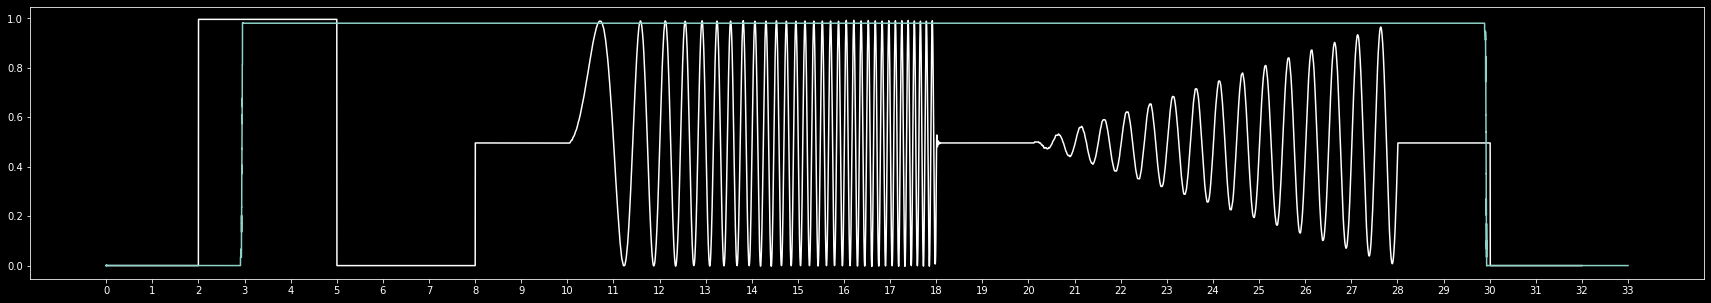

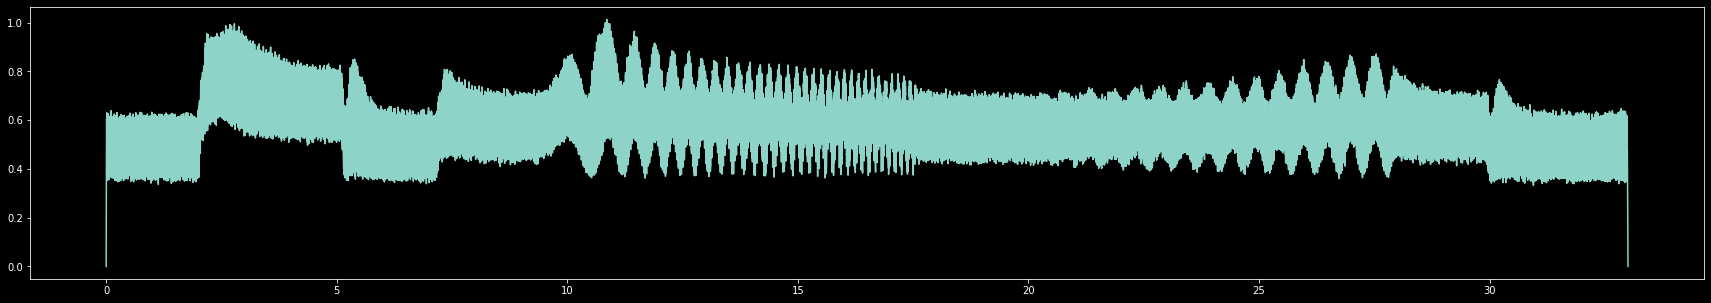

In [317]:
# plt.plot(raw_dat[3].flatten())
print(raw_dat.shape)
print(2**14, M['chirp_time'].min(), M['chirp_time'].max() - M['chirp_time'].min())

plt.figure(figsize=(30,5))
plt.plot(np.linspace(0,32,31988),M['chirp_stim']/256, color='w')
plt.xticks(np.arange(34))
plt.plot(np.linspace(0, 33, 4435968),raw_dat[:,trial_ind,3,:].mean(axis=1).reshape((-1))/2**14)

plt.figure(figsize=(30,5))
plt.plot(np.linspace(0, 33, 4301799),np.convolve(raw_dat[33:,trial_ind,1,:].mean(axis=1).reshape((-1)), np.ones(1000))/1e5)


(1083, 41, 29)


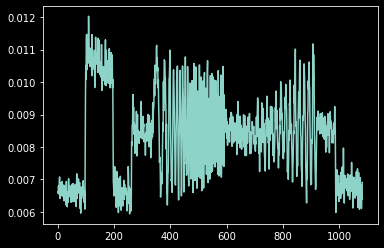

In [325]:
# print(np.r_['-1',10:20,80:93].shape, len(trial_ind))

# print(dFoF[:,trial_ind,np.r_[10:20,30:48,80:93][:,np.newaxis]].shape)
# plt.plot(dFoF[:,trial_ind,np.r_[10:20,80:93][:,np.newaxis]].mean(axis=(1,2)))

print(g[:,trial_ind,np.r_[10:20,30:48,80:93][:,np.newaxis]].shape)
plt.plot(g[:,trial_ind,np.r_[10:20,80:93][:,np.newaxis]].mean(axis=(1,2)))



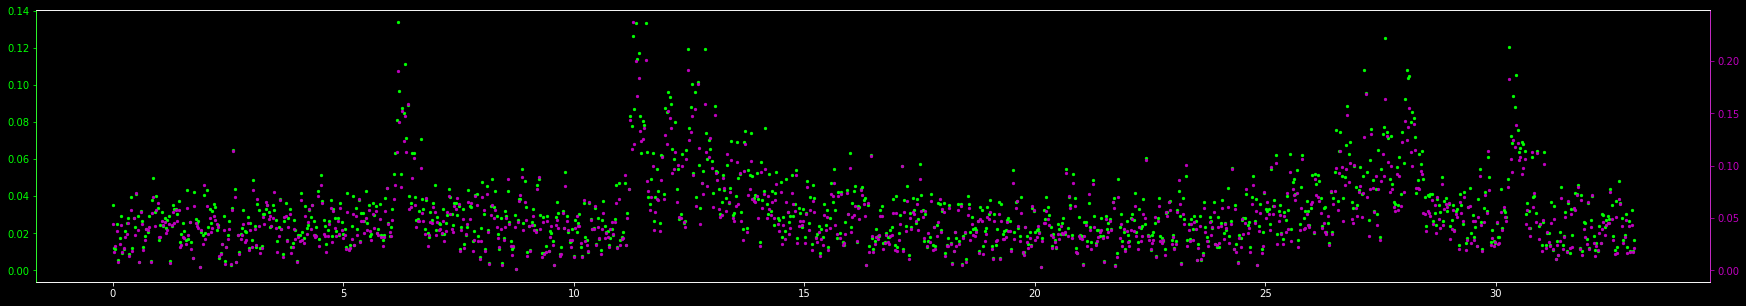

In [310]:
# dFoF[:,trial_ind,:].shape

plt.style.use(['dark_background'])
plt.figure(figsize=(30,5))
plt.scatter(np.linspace(0,33,1083), g[:,trial_ind[0], 77], s=5, color=[0,1,0])

# plt.figure(figsize=(30,5))
plt.gca().tick_params(axis='y',color=[0,1,0], labelcolor=[0,1,0])
# plt.gca().tick_params(axis='x',color='k', labelcolor='k')

ax2 = plt.gca().twinx()
plt.scatter(np.linspace(0,33,1083), gr[:,trial_ind[0], 77], s=5, color='m')
plt.gca().tick_params(axis='y',color='m', labelcolor='m')

plt.gca().spines['left'].set_color([0,1,0])
plt.gca().spines['right'].set_color('m')



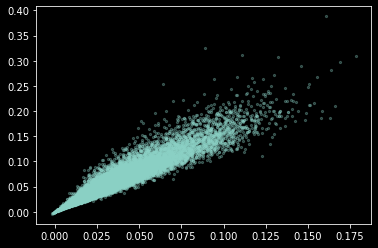

In [315]:
plt.scatter(g[:,trial_ind, 77].flatten(), gr[:,trial_ind, 77].flatten(), s=5, alpha=.3)